# SMAI Assignment - 2

## Question - `4` : Gaussian Naïve Bayes

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `16.02.2023` |
| Due Date | `24.02.2023` |

This question will have you working and experimenting with the Gaussian Naïve Bayes classifier. Initially, you will calculate the priors and the parameters for the Gaussians. Then, you will use the likelihoods to classify the test data. Please note that use of `sklearn` implementations is only for the final question in the Experiments section.

The dataset is simple and interesting, the [Wireless Indoor Localization Data Set](https://archive.ics.uci.edu/ml/datasets/Wireless+Indoor+Localization). An office has seven Wi-Fi routers and its signal strengths received from these routers categorize the location of the receiver (in one of four rooms). There are 7 attributes and a class label column that can take 4 values. The data is present in `wifiLocalization.txt`. It contains 2000 samples.

### Imports

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import math

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [78]:
# load data

data = np.loadtxt("wifiLocalization.txt", dtype=np.float32, skiprows=1)
np.random.shuffle(data)

trainAmt = 0.75
limit = int(trainAmt * data.shape[0])

trainX = data[:limit, :-1]
trainY = data[:limit, -1].astype(int)

testX = data[limit:, :-1]
testY = data[limit:, -1].astype(int)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(1500, 7) (1500,)
(500, 7) (500,)


### Estimate Gaussian parameters

Write a function to estimate the parameters of the Gaussian distribution.

In [79]:
def getParams(trainX, trainY):
    classes = np.unique(trainY)

    means = np.empty((classes.shape[0], trainX.shape[1]))
    stds = np.empty((classes.shape[0], trainX.shape[1]))

    # estimate means and standard deviations through MLE estimation
    # convert to logs, equate partial derivative to 0
    for i, c in enumerate(classes):
        # mu
        matchingX = trainX[trainY == c]
        mus = matchingX.sum(axis=0) / matchingX.shape[0]

        # sigma
        matchingX -= mus
        sigmas = np.sqrt(np.square(matchingX).sum(axis=0) / matchingX.shape[0])

        # store and return
        means[i, :] = mus
        stds[i, :] = sigmas

    return means, stds


mus, sigmas = getParams(trainX, trainY)

### Calculate priors

Write a function to calculate the priors for each class.

In [80]:
# estimate priors solely by counts
def getPriors(trainX, trainY):
    classes, counts = np.unique(trainY, return_counts=True)
    classes = classes.astype(int)

    priors = counts / trainY.shape

    return classes, priors
    
classes, priors = getPriors(trainX, trainY)

### Likelihood + Classification

Given a test sample, write a function to get the likelihoods for each class in the sample. Use the Gaussian parameters and priors calculated above. Then compute the likelihood that the sample belongs to each class and return the class with the highest likelihood.

What is a common problem with the likelihoods? How can you fix it? Redo the classification with the fixed likelihoods. (You can either write another function or modify the existing one after mentioning the reason for the change)

In [81]:
def getLikelihood(x, mu, sigma):
    val = -((x - mu) ** 2) / (2 * sigma ** 2)
    val = np.e ** val
    val /= (sigma * np.sqrt(2*np.pi))
    return val

def classify(x, priors, mus, sigmas):
    numClasses = priors.shape[0]
    likelihoods = np.log(priors)
    
    # over each value in x
    for i, xi in enumerate(x):
        for c in range(numClasses):
            likelihoods[c] += np.log(getLikelihood(xi, mus[c, i], sigmas[c, i]))

    return np.argmax(likelihoods) + 1

pred = classify(testX[0], priors, mus, sigmas)
print("Predicting the class of: ", testX[0])
print("Predicted class: ", pred, " | Actual class: ", testY[0])

Predicting the class of:  [-56. -53. -58. -64. -71. -84. -87.]
Predicted class:  1  | Actual class:  1


### Experiments

1. Estimate your model on the training data.
2. Plot the Gaussian probability density functions for each class after estimation.
3. Classify the test data using your model.
4. Pick a few samples from the test set that were misclassified and plot them along with the Gaussian probability density functions for each class. What do you observe?
5. Find if there are any features that are redundant. If so, remove them and repeat the experiments. How does the performance change?
6. Conversely, are there certain features that overpower the likelihood scores independently? Test this hypothesis empirically by only using hat/those feature(s) and repeating the experiments. How does the performance change?
7. Compare your results with the `scikit-learn` implementation. You can use the `GaussianNB` class from `sklearn.naive_bayes`. You can use the `score` function to get the accuracy of the model on the test set.
8. (Optional) Try other Naïve Bayes classifiers from [`sklearn.naive_bayes`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) and compare the results.

In [88]:
# estimating on train data

correct = 0
count = trainX.shape[0]

for x, y in zip(trainX, trainY):
    pred = classify(x, priors, mus, sigmas)
    if pred == y:
        correct += 1

print("%d correct out of %d on training data | Accuracy = %.2f" % (correct, count, 100 * float(correct/count)))

1478 correct out of 1500 on training data | Accuracy = 98.53


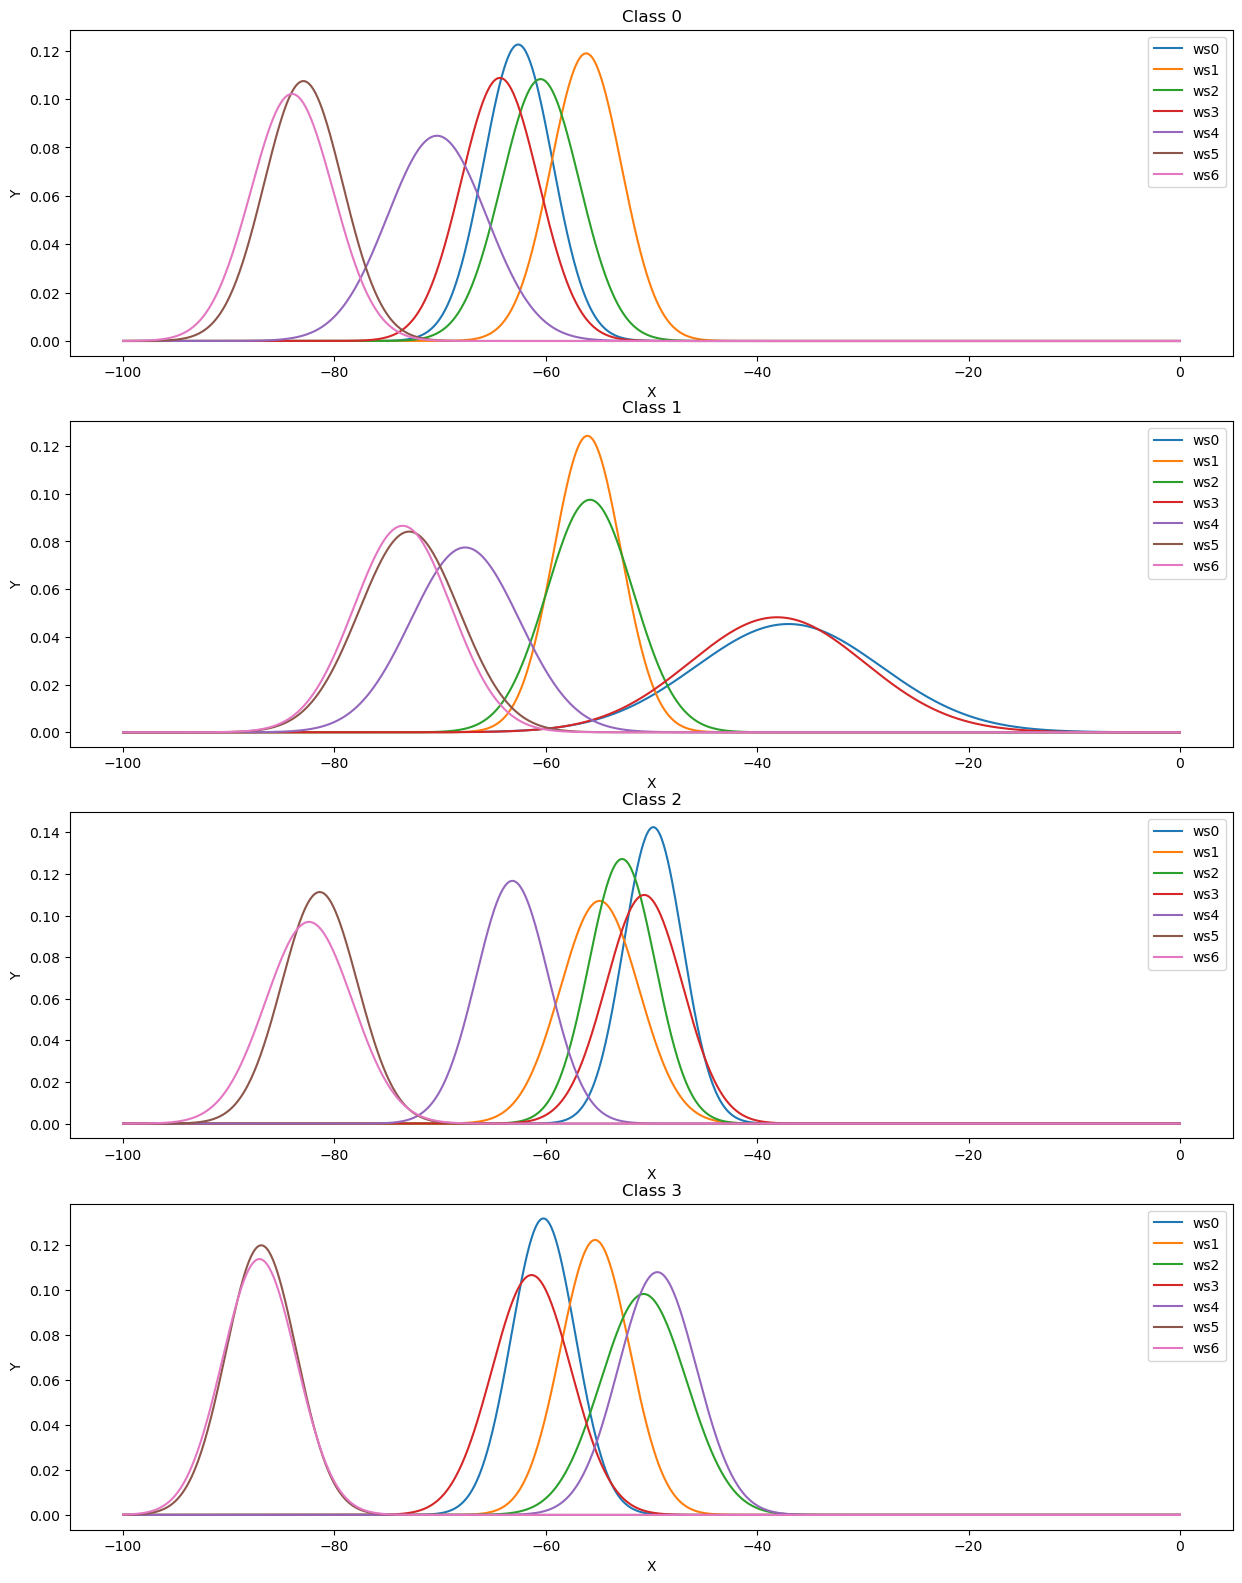

In [119]:
# plot gaussians

x = np.linspace(-100, 0, 1000)
fig, axes = plt.subplots(4, 1, figsize=(15,15))

# plot as ws'es
for i in range(mus.shape[0]):
    for c in range(mus.shape[1]):
        y = 1/(sigmas[i, c]*np.sqrt(2*np.pi))*np.exp(-(x-mus[i, c])**2/(2*sigmas[i, c]**2))
        axes[i].plot(x, y, label="ws%d" % c)

    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Y")
        
    axes[i].set_title("Class %d" % i)
    axes[i].legend()

plt.subplots_adjust(bottom=0, top=1)
plt.show()


In [121]:
# classify on test data and get some misclassified data

correct = 0
count = testX.shape[0]

misclassified = []

for x, y in zip(testX, testY):
    pred = classify(x, priors, mus, sigmas)
    if pred == y:
        correct += 1
    else:
        misclassified.append([x, pred, y])

print("%d correct out of %d on training data | Accuracy = %.2f" % (correct, count, 100 * float(correct/count)))

490 correct out of 500 on training data | Accuracy = 98.00


[[-50. -50.]
 [-57. -57.]
 [-59. -59.]
 [-43. -43.]
 [-62. -62.]
 [-76. -76.]
 [-78. -78.]] [[0.   0.15]
 [0.   0.15]
 [0.   0.15]
 [0.   0.15]
 [0.   0.15]
 [0.   0.15]
 [0.   0.15]]


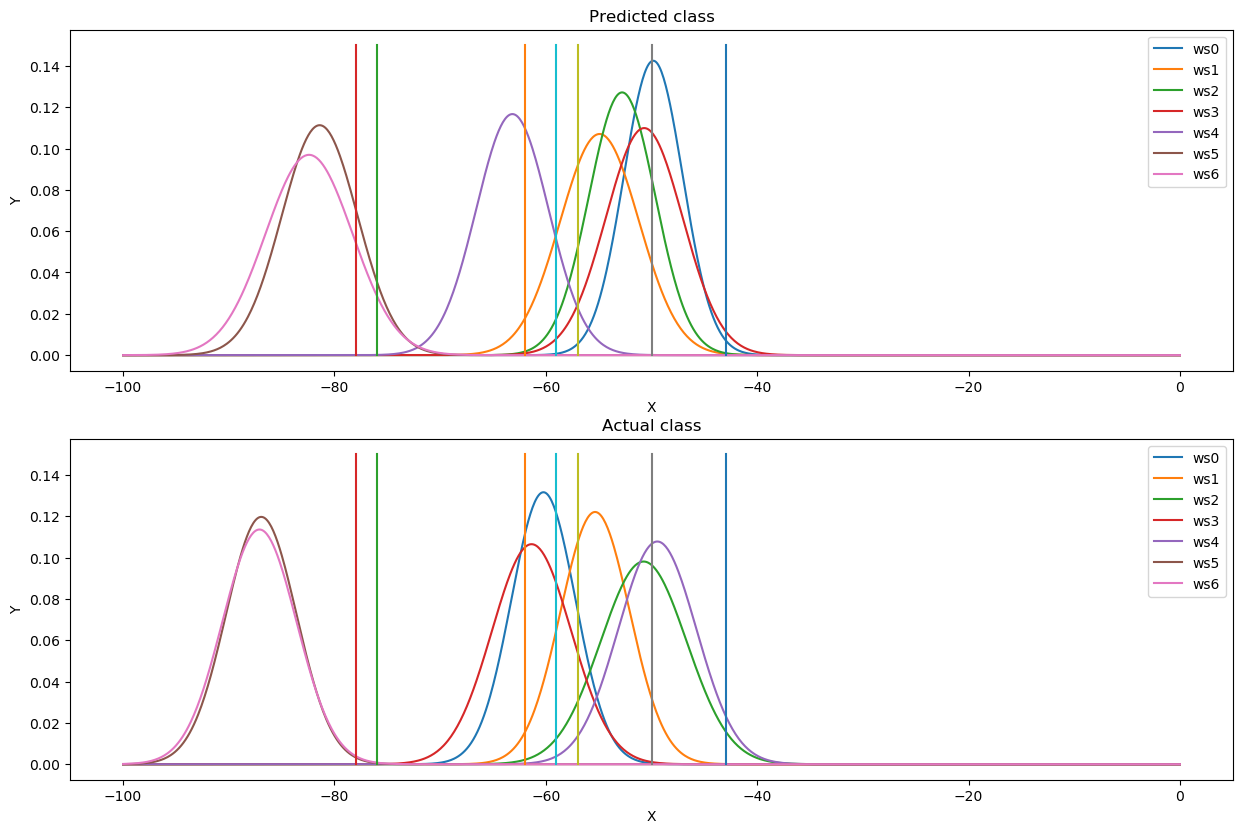

In [177]:
# visualise misclassified values

sample1 = misclassified[0]

x = np.linspace(-100, 0, 1000)
fig, axes = plt.subplots(2, 1, figsize=(15,15))

# get lines to show attributes
lineX = np.tile(sample1[0], (2,1)).T
lineY = np.tile([0, 0.15], (sample1[0].shape[0],1))
print(lineX, lineY)
# axes[plotNum].vlines(sample1[0][c], 0, 0.2)

# plot as ws'es
for plotNum, i in enumerate(sample1[1:]):
    # plt.gca().set_prop_cycle(None)
    for c in range(mus.shape[1]):
        y = 1/(sigmas[i, c]*np.sqrt(2*np.pi))*np.exp(-(x-mus[i, c])**2/(2*sigmas[i, c]**2))
        axes[plotNum].plot(x, y, label="ws%d" % c)

        

    plt.gca().set_prop_cycle(None)
    axes[plotNum].plot(lineX.T, lineY.T)

    axes[plotNum].set_xlabel("X")
    axes[plotNum].set_ylabel("Y")
    axes[plotNum].legend()

axes[0].set_title("Predicted class")
axes[1].set_title("Actual class")

plt.subplots_adjust(bottom=0, top=0.5)
plt.show()